In [1]:
from sklearn.model_selection import KFold
import pickle
import pandas as pd
import os.path
file_name = 'resampled_2x5_cross_validation'
if os.path.isfile(file_name+'.pickle'): 
    with open(file_name+'.pickle', 'rb') as handle:
        train_folds,test_folds = pickle.load(handle)  

In [2]:
import torch.nn as nn
import torch
import torchvision
import torch.nn.functional as F
class Block(nn.Module):
    def __init__(self, in_ch, out_ch,kernel_size=None,stride=None):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))
class Encoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64),kernel_size=3,stride=None):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1],kernel_size=kernel_size,stride=stride) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool1d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64),kernel_size=None,stride=None):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose1d(chs[i], chs[i+1], kernel_size=kernel_size, stride=stride) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1],kernel_size=kernel_size, stride=stride) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([1, W])(torch.unsqueeze(enc_ftrs, 2))
        return enc_ftrs.squeeze(2)
class UNet(nn.Module):
    def __init__(self, device=None,kernel_size=None, stride=None, enc_chs=None, dec_chs=None, num_class=1, retain_dim=True, out_sz=None):
        super().__init__()
        self.encoder     = Encoder(enc_chs,kernel_size=kernel_size,stride=stride)
        self.decoder     = Decoder(dec_chs,kernel_size=kernel_size,stride=stride)
        self.head        = nn.Conv1d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz = out_sz
        self.linear = nn.LazyLinear(self.out_sz)
        self.mylinear = nn.Linear(64, 250) #add based on the paper
        self.to(device) 
        self.device=device

    def forward(self, x):
        x = self.mylinear(x.unsqueeze(1)) #add based on the paper
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = self.linear(out)
            out = (x + out) #add based on the paper
            #print(out)
            out = torch.sigmoid(out)
        return out.squeeze(1)    

In [3]:
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
from tqdm import trange
class CalculateMSE():
    def __init__(self, net,n_epochs,batch_size ):
        super().__init__()
        self.net = net
        #initialize some constants
        self.batch_size = 32
        self.learning_rate = 1e-4
        self.n_epochs = n_epochs
        self.net.apply(self.weights_init)   
    def weights_init(self,layer):
        if type(layer) == nn.Linear:
            nn.init.orthogonal_(layer.weight)
    def get_mse(self,train_data, train_label, test_data, test_label):
        train_set = torch.utils.data.TensorDataset(
            torch.Tensor(train_data), 
            torch.Tensor(train_label))
        val_set = torch.utils.data.TensorDataset(
            torch.Tensor(test_data), 
            torch.Tensor(test_label))
        loader_args = dict(batch_size=self.batch_size)
        train_loader = DataLoader(train_set, shuffle=True, drop_last=True, **loader_args)
        val_loader = DataLoader(val_set, shuffle=True, drop_last=True, **loader_args)
        tloss = []
        vloss = []
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate) # weight_decay=0
        for epoch in trange(0, self.n_epochs):
            epoch_train_loss=[]
            for i, data in enumerate(train_loader, 0):
                inputs, label = data
                y_pred = self.net(inputs.to(self.net.device))
                loss = criterion(y_pred, label.to(self.net.device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_train_loss.append(loss.item())
            tloss.append(np.mean(epoch_train_loss))
            epoch_loss=[]
            for i, data in enumerate(val_loader, 0):
                with torch.no_grad():
                    inputs1, label1 = data
                    y_pred1 = self.net(inputs1.to(self.net.device))
                    loss1 = criterion(y_pred1, label1.to(self.net.device))
                    epoch_loss.append(loss1.item())
            vloss.append(np.mean(epoch_loss))
        return np.min(vloss), self.net


In [4]:
from pathlib import Path
n_epochs=3000
batch_size=32
PATH = 'saved_model/UNet_combined_poisson_30percent/'
Path(PATH).mkdir(parents=True, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#define parameters
chs_encoder = (1,64,128,256)  #tuple of channels/feature dimensions
chs_decoder=(256, 128, 64) #inverse of encoder
kernel_size=3 #kernel size for convolution
stride=1
mdl = UNet(kernel_size=kernel_size,stride=stride,enc_chs=chs_encoder,dec_chs=chs_decoder,out_sz=250,device=device
          )
losses = []
from scipy.stats import poisson
def add_noise(inputs,inputs2, a = 0.02, std = 0.02, sequence_length=64, noise_seed=None):
    if noise_seed is not None:
        np.random.seed(noise_seed)
    noise = np.random.normal(0,std, size = (inputs.shape[0], sequence_length)).astype(np.float32)
    noise2 = np.random.normal(0,std, size = (inputs2.shape[0], sequence_length)).astype(np.float32)
    #noise = poisson.rvs(mu, size=(inputs.shape[0], sequence_length)).astype(np.float32)
    
    nsd = a*np.random.poisson(inputs/a).astype(np.float32)
    nsd2 = a*np.random.poisson(inputs2/a).astype(np.float32)
    
    # Calculate the absolute error between nsd and original inputs
    absolute_error = np.abs(nsd - inputs)
    absolute_error2 = np.abs(nsd2 - inputs2)
    # Sum up the absolute errors
    total_error = np.sum(absolute_error)
    total_error2 = np.sum(absolute_error2)
    # Sum of the original data
    total_original = np.sum(inputs)
    total_original2 = np.sum(inputs2)

    # Calculate the noise ratio
    noise_ratio = (total_error+total_error2) / (total_original+total_original2)
    
    return nsd, nsd2, noise_ratio
noise_ratios = []
for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    # Adding noise to the train and test data
    train_data,test_data,noise_ratio = add_noise(train_data,test_data, a=0.058,std = 0.05, sequence_length=64, noise_seed=i)
    print(noise_ratio)
    noise_ratios.append(noise_ratio)
    mse_calculator = CalculateMSE(mdl,n_epochs,batch_size)
    loss,model = mse_calculator.get_mse(train_data, train_label, test_data, test_label)
    losses.append(loss)
    print(i,loss)
    torch.save(model.state_dict(), PATH+'model'+str(i))
print(np.mean(noise_ratios))

/home/research/junbo.s/.conda/envs/new_env/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


0.2991638516368172


100%|██████████| 3000/3000 [05:36<00:00,  8.91it/s]


0 0.032321386784315106
0.30001349371568536


100%|██████████| 3000/3000 [05:36<00:00,  8.93it/s]


1 0.031203974224627017
0.30083086123556907


100%|██████████| 3000/3000 [05:35<00:00,  8.95it/s]


2 0.023414965346455575
0.30097298174478687


100%|██████████| 3000/3000 [05:35<00:00,  8.95it/s]


3 0.030236200243234635
0.29975233389828004


100%|██████████| 3000/3000 [05:33<00:00,  9.01it/s]


4 0.018472970090806486
0.2992994934645396


100%|██████████| 3000/3000 [05:33<00:00,  8.99it/s]


5 0.022102175280451775
0.30073801023410157


100%|██████████| 3000/3000 [05:32<00:00,  9.03it/s]


6 0.02488577589392662
0.3009065363556807


100%|██████████| 3000/3000 [05:32<00:00,  9.02it/s]


7 0.024359444342553615
0.29975297467000084


100%|██████████| 3000/3000 [05:34<00:00,  8.96it/s]


8 0.02513831965625286
0.30008254071360696


100%|██████████| 3000/3000 [05:34<00:00,  8.97it/s]

9 0.02322656512260437
0.3001513077669068


In [5]:
print(np.mean(losses),np.std(losses))

0.025536177698522806 0.004168145067661762


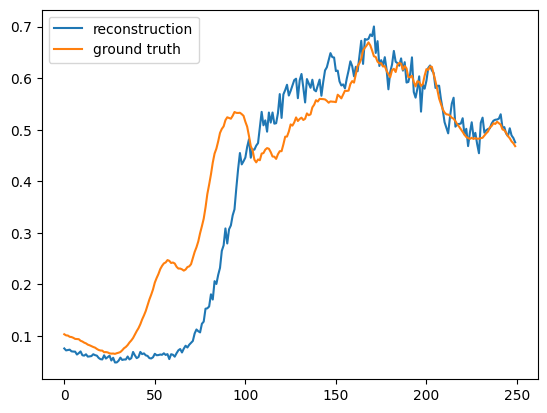

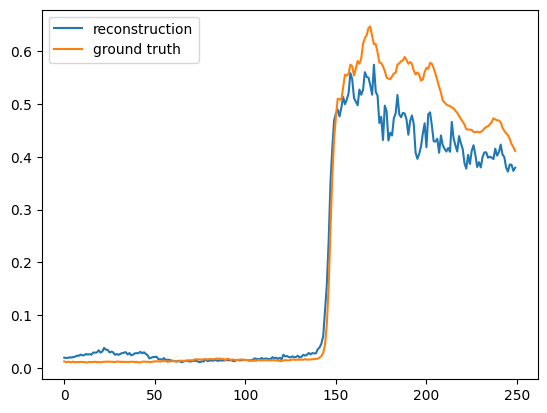

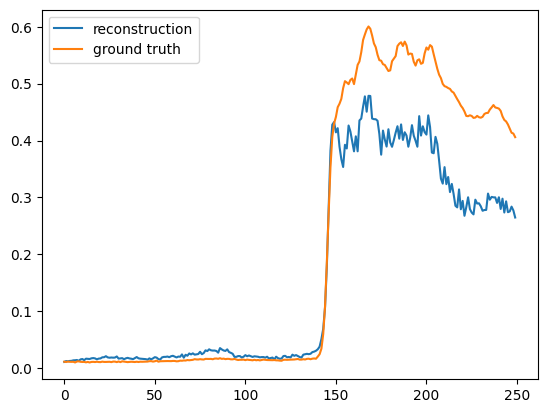

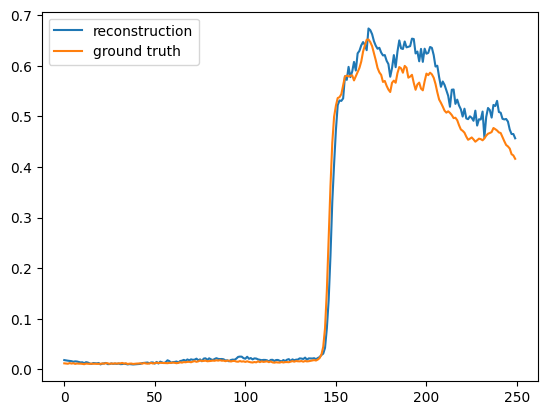

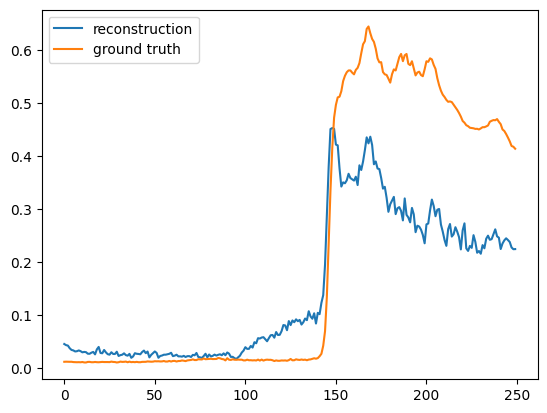

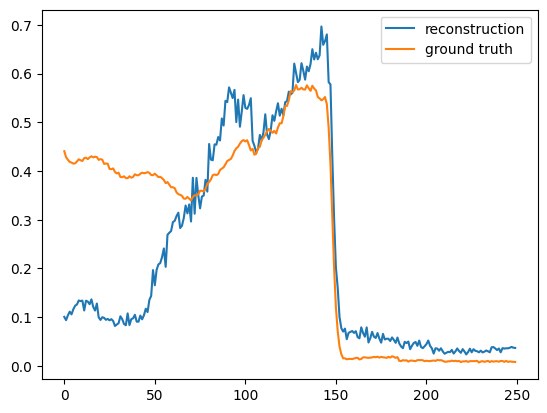

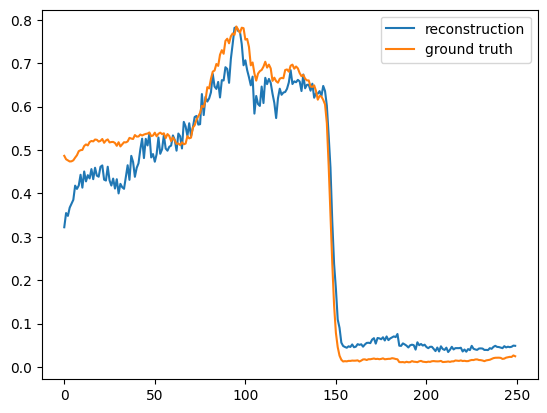

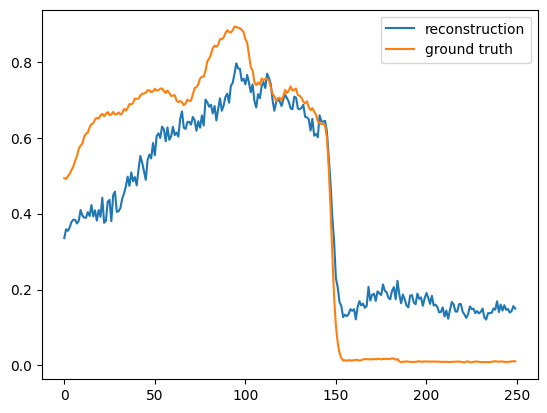

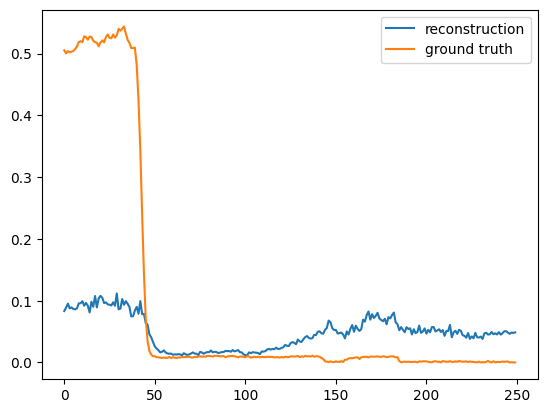

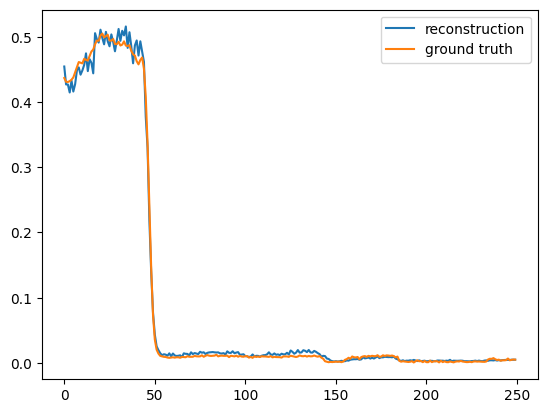

In [6]:
number_figures = 10
import matplotlib.pyplot as plt

indices = torch.randint(0,len(test_data),(number_figures,)).unique()
for i in indices:
    res = test_data[i].reshape(1,-1)
    spec = test_label[i]
    plt.figure(i)

    plt.plot(model(torch.Tensor(res).to(model.device)).detach().cpu().flatten())
    plt.plot(spec)
    plt.legend(['reconstruction','ground truth'])

In [7]:
# number_figures = 10
# import matplotlib.pyplot as plt
# device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# #define parameters
# chs_encoder = (1,64,128,256)  #tuple of channels/feature dimensions
# chs_decoder=(256, 128, 64) #inverse of encoder
# kernel_size=3 #kernel size for convolution
# stride=1
# model = UNet(kernel_size=kernel_size,stride=stride,enc_chs=chs_encoder,dec_chs=chs_decoder,out_sz=250,device=device
#           )
# PATH = 'saved_model/UNet/'
# import numpy as np
# stats = np.zeros((2000,3))
# k=0
# for i,(train,test) in enumerate(zip(train_folds,test_folds)):
#     print(i)
#     train_data, train_label= train[0],train[1]
#     test_data, test_label= test[0],test[1]
    
#     mdl_name = PATH + 'model' + str(i)
#     model.load_state_dict(torch.load(mdl_name))
#     model.eval()
#     for j in range(len(test_data)):
#         res = test_data[j].reshape(1,-1)
#         spec = test_label[j].flatten()
#         reconstructed = model(torch.Tensor(res).to(model.device)).detach().cpu().flatten()
#         stats[k] = [i,j, torch.mean((reconstructed -spec) **2).item()]
#         k+=1
# k_plot = 20
# sorted_stats = stats[stats[:,2].argsort()[::-1]]
# for ii in range(k_plot):
#     i,j,mse = sorted_stats[ii]
#     test_data, test_label = test_folds[int(i)]
#     res = test_data[int(j)].reshape(1,-1)
#     spec = test_label[int(j)]
#     plt.figure(ii)
#     plt.title('mse is ' + str(mse))
#     plt.plot(model(torch.Tensor(res).to(model.device)).detach().cpu().flatten())
#     plt.plot(spec)
#     plt.legend(['reconstruction','ground truth'])


In [8]:
from pathlib import Path
PATH = 'saved_model/UNet_combined_poisson_30percent/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#define parameters
chs_encoder = (1,64,128,256)  #tuple of channels/feature dimensions
chs_decoder=(256, 128, 64) #inverse of encoder
kernel_size=3 #kernel size for convolution
stride=1
mdl = UNet(kernel_size=kernel_size,stride=stride,enc_chs=chs_encoder,dec_chs=chs_decoder,out_sz=250,device=device
          )

from scipy import stats,spatial
#pip install dtw-python
from dtw import *
import torch
import numpy as np
correlation_losses = []
import dcor
def calculate_correlation(model, test_data, test_label):
    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
    construction = model(test_data_tensor).detach().cpu().numpy()
   
    # Pearson
    pearson_coefs = []
    pearson_ps = []
    
    # Kendall
    kendall_coefs = []
    kendall_ps = []
    
    # Spearman
    spearman_coefs = []
    spearman_ps = []
    
    # Distance Correlation
    distance_corr = []
    
    #DTW distance
    alignment = []
    
    #absolute_error
    abs_err = []
    
    for i in range(test_label.shape[0]):
        x1 = construction[i,:]
        x2 = test_label[i,:]
        
        res = stats.pearsonr(x1, x2)
        pearson_coefs.append(res[0])
        pearson_ps.append(res[1])
        
        res = stats.kendalltau(x1, x2)
        kendall_coefs.append(res[0])
        kendall_ps.append(res[1])
        
        res = stats.spearmanr(x1, x2)
        spearman_coefs.append(res[0])
        spearman_ps.append(res[1])
        
        distance_corr.append(dcor.distance_correlation(x1,x2))
        
        alignment.append(dtw(x1, x2, distance_only=True).distance)
        abs_err.append(abs(x1-x2))
        
    correlation_results = {
        'pearson': (pearson_coefs, pearson_ps),
        'kendall': (kendall_coefs, kendall_ps),
        'spearman': (spearman_coefs, spearman_ps),
        'DTW': alignment,
        'Absolute Error': abs_err,
        'Distance Correlation': distance_corr
    }

    return correlation_results

for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    print(i)
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    # Adding noise to the train and test data
    train_data,test_data,noise_ratio = add_noise(train_data,test_data, a=0.058,std = 0.05, sequence_length=64, noise_seed=i)
    
    mdl_name = PATH + 'model' + str(i)
    mdl.load_state_dict(torch.load(mdl_name))
    mdl.eval()
    
    correlation_loss = calculate_correlation(mdl, test_data, test_label)
    correlation_losses.append(correlation_loss)
for key in correlation_losses[0].keys():
    print(key)
    if key=='Absolute Error':
        errors = []
        for d in correlation_losses:
            errors+=np.concatenate(d[key]).ravel().tolist()
        #percentile
        percentiles = [5, 50, 90, 95, 99]
        for p in percentiles:
            print(p)
            print(np.percentile(errors, p))
    else:
        stat, p = [], []
        for d in correlation_losses:
            if key=='DTW' or key=='Distance Correlation':
                stat+=d[key]
            else:
                stat+=d[key][0]
                p+=d[key][1]
        print(np.mean(stat),np.std(stat))
        if len(p)>0:
            print(np.mean(p),np.std(p))

/home/research/junbo.s/.conda/envs/new_env/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

0


/home/research/junbo.s/.conda/envs/new_env/lib/python3.10/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


1
2
3
4
5
6
7
8
9
pearson
0.7388446290143298 0.42816260194858674
0.013115909445316777 0.0895101494492176
kendall
0.5385045402468015 0.30496534760196137
0.016903574835990583 0.0986866557590517
spearman
0.6682124942232716 0.38706783658654187
0.01739323745037663 0.09700884224783043
DTW
18.530180128835596 21.96450747633041
Absolute Error
5
0.0012273674865345946
50
0.04127792870495417
90
0.30499420334746413
95
0.4403031004020839
99
0.6643253566642248
Distance Correlation
0.8441236327604623 0.20743529557335472
